In [2]:
library(tidyverse)
library(ComplexHeatmap)
library(colorRamp2)
library(GetoptLong)

## Visualization heatmaps for selected genes using ComplexHeatmap

In [3]:
bulk <- readRDS("merged_log2tpm_Donlin-IM-17554_2024_11_26_bulkrna.rds")
dim(bulk)
# bulk[1:4,]

meta <- readRDS("merged_meta_Donlin-IM-17554_2024_11_26.rds")
dim(meta)
# meta[1:4,]

all(colnames(bulk) == meta$name)

[1] 12861    48

[1] 48 52

[1] TRUE

In [4]:
table(meta$group)


            M_CSF         M_CSF_C5a        M_CSF_IL_6    M_CSF_IL_6_C5a 
                6                 6                 6                 6 
        SFs_M_CSF     SFs_M_CSF_C5a SFs_M_CSF_C5a_TCZ     SFs_M_CSF_TCZ 
                6                 6                 6                 6 

In [7]:
# Specify "gene_all"
length(gene_all)

[1] 138

In [8]:
exp_heat <- bulk[which(rownames(bulk) %in% gene_all),]  # Subset gene
exp_heat <- t(exp_heat)
exp_heat <- as.data.frame(as.matrix(exp_heat))
all(rownames(exp_heat) == meta$name)

# exp_heat$group_sam <- paste0(meta$group, "_", meta$name, sep = "") # keep per condition per name
exp_heat$group_sam <- paste0(meta$group)  # keep per condition
dim(exp_heat)
colnames(exp_heat)


exp_ave <- aggregate(exp_heat[, 1:(ncol(exp_heat)-1)], list(exp_heat$group_sam), median)
colnames(exp_ave)[1] <- "clu_dis_sam"
exp_ave <- as.data.frame(t(exp_ave))
colnames(exp_ave) <- as.character(t(exp_ave[1,]))
exp_ave <- exp_ave[-1,]
row_names <- rownames(exp_ave)

exp_ave <- mutate_all(exp_ave, function(x) as.numeric(as.character(x)))
rownames(exp_ave) <- row_names
dim(exp_ave)
                      
exp_ave <- as.matrix(exp_ave)
scale_rows <- function(x) t(scale(t(x)))
exp_ave_scale <- scale_rows(exp_ave) # Z-score
exp_ave_scale[exp_ave_scale > 2] <- 2
exp_ave_scale[exp_ave_scale < -2] <- -2
                      
exp_ave_scale <- exp_ave_scale[complete.cases(exp_ave_scale), ]
dim(exp_ave_scale)

[1] TRUE

[1]  48 137

[1] "ADAMTS2"        "AOC3"           "ARG2"           "BCL2A1"        
  [5] "BEND3P2"        "BMP6"           "C2"             "C3orf70"       
  [9] "CARMIL3"        "CAVIN4"         "CCL1"           "CCL13"         
 [13] "CCL18"          "CCL22"          "CCL4"           "CCL4L2"        
 [17] "CCN3"           "CCND1"          "CD226"          "CD300LB"       
 [21] "CD52"           "CDC42EP1"       "CHST2"          "CNIH3"         
 [25] "COL5A3"         "CPNE6"          "CSPG4"          "CTXN1"         
 [29] "CXCL1"          "CXCL3"          "CXCL5"          "DCHS1"         
 [33] "DCSTAMP"        "DEPP1"          "DUSP1"          "DUSP14"        
 [37] "DUSP5"          "ENO2"           "EPOP"           "EREG"          
 [41] "FABP4"          "FANCE"          "FCGBP"          "FCGR1CP"       
 [45] "FJX1"           "FPR1"           "FZD5"           "GAL"           
 [49] "GCHFR"          "GEM"            "GM2A"           "GNG11"         
 [53] "GNG12"          "GPC1"           "GREM1"          "GRPR"          
 [57] "H2BC12"         "HRH2"           "ICAM1"          "ICAM5"         
 [61] "IER3"           "IFITM10"        "IFNG"           "IGFBP6"        
 [65] "IRF7"           "ITGB3"          "KCNF1"          "KIAA1210"      
 [69] "KRT79"          "LIF"            "LILRA3"         "LOC102724428"  
 [73] "LRP6"           "LRRC38"         "LYVE1"          "MAS1"          
 [77] "MC1R"           "METRNL"         "METTL7B"        "MMP1"          
 [81] "MMP12"          "MMP7"           "MMP9"           "MSANTD3-TMEFF1"
 [85] "MSC"            "MYEOV"          "NAMPTP1"        "NOTCH3"        
 [89] "NPPC"           "OCSTAMP"        "OLR1"           "OTUD7B"        
 [93] "PCGF2"          "PCOLCE2"        "PHLDA3"         "PIGR"          
 [97] "PLEK2"          "PLEKHF1"        "PPBP"           "PPP1R14C"      
[101] "PROCR"          "RGS16"          "RHOF"           "RHOU"          
[105] "RNASE2"         "RTN4RL2"        "SBNO2"          "SCG5"          
[109] "SDC4"           "SERPINA1"       "SERPINB9"       "SERPINE1"      
[113] "SLC22A4"        "SLC28A3"        "SLC43A1"        "SLC51B"        
[117] "SLC7A5"         "SOCS1"          "SOCS3"          "SOD3"          
[121] "SRPX2"          "ST6GALNAC6"     "STAC2"          "STEAP1"        
[125] "TBX21"          "TMEM45B"        "TMEM52B"        "TNFRSF10D"     
[129] "TNFRSF21"       "TNFRSF6B"       "TPBGL"          "TRNP1"         
[133] "TSPAN13"        "VANGL2"         "XIRP1"          "ZSWIM4"        
[137] "group_sam"

[1] 136   8

[1] 136   8

## Label only selected genes

In [18]:
row_order <- hclust(dist(exp_ave_scale))$order
exp_ave_scale_new <- exp_ave_scale[row_order,]

# Use the hierarchically clustered order
ha = rowAnnotation(foo = anno_mark(at = which(rownames(exp_ave_scale_new) %in% gene_label), 
                                   labels = rownames(exp_ave_scale_new)[which(rownames(exp_ave_scale_new) %in% gene_label)],
                                   labels_gp = gpar(fontsize= 12)
                                  )
                  )

f1 = colorRamp2(seq(min(exp_ave_scale), max(exp_ave_scale), length = 3), c("blue", "#EEEEEE", "orange"), space = "RGB")


# Save the pdf version
pdf(qq("heatmap_plot_selected_gene_label.pdf"), width = 4, height = 6)
test = Heatmap(exp_ave_scale_new, cluster_rows = FALSE, cluster_columns = TRUE, right_annotation = ha, name = "scaled\nexpression", col = f1, 
               column_names_rot = 45,  column_title = "",
               row_names_side = "left", row_names_gp = gpar(fontsize = 2)
              )
draw(test)
dev.off()

pdf 
  2

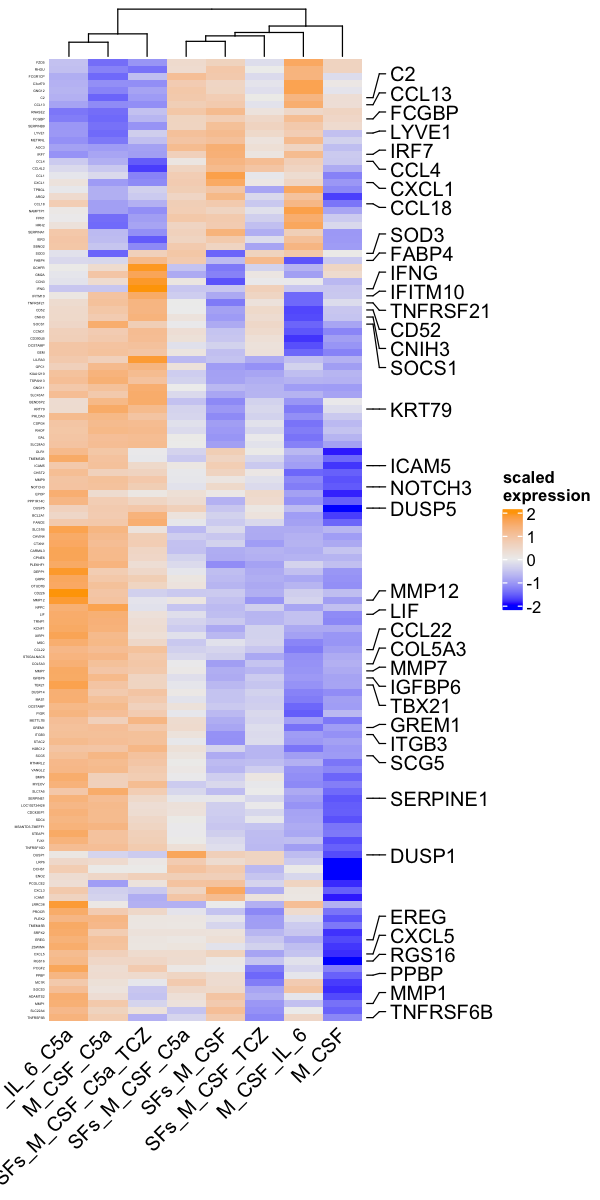

In [19]:
# Show the plot
options(repr.plot.height = 10, repr.plot.width = 5)
draw(test)